In this notebook, I have implemented Yolo v5 Algorithm in **Tensorflow** for Detecting the presence and position of crown-of-thorns starfish in sequences of underwater images around the Great Barrier Reef. The Dataset used in this notebook is from recent **Tensorflow - Help Protect the Great Barrier Reef** competition .

> Detect crown-of-thorns starfish in underwater image data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/31703/logos/header.png?t=2021-10-29-00-30-04">

# Table of Contents
<a id="toc"></a>
[1. Introduction to Yolov5  ](#1)<br>
[2. Reading Csv  ](#2)<br>
[3. prepare and split data into groupkfold](#3)<br>
[4. Data Reader  ](#4)<br>
[5. Augmentation  ](#5)<br>
[6. Utility Function  ](#6)<br>
[7.Model Architecture ](#7)<br>
[8.Model Class ](#8)<br>
[9. Yolo Loss   ](#9)<br>
[10. Training  ](#10)<br>

# <center><span style="color:#00BFC4;"> Introduction to Yolov5 </span></center> 
<a id="1"></a>

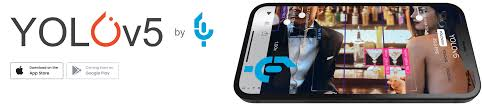

YOLO is an acronym that stands for You Only Look Once that was launched by Ultralytics in June 2020 and is now the most advanced object identification algorithm available. It is a novel convolutional neural network (CNN) that detects objects in real-time with great accuracy. This approach uses a single neural network to process the entire picture, then separates it into parts and predicts bounding boxes and probabilities for each component. These bounding boxes are weighted by the expected probability. The method “just looks once” at the image in the sense that it makes predictions after only one forward propagation run through the neural network. It then delivers detected items after non-max suppression (which ensures that the object detection algorithm only identifies each object once).

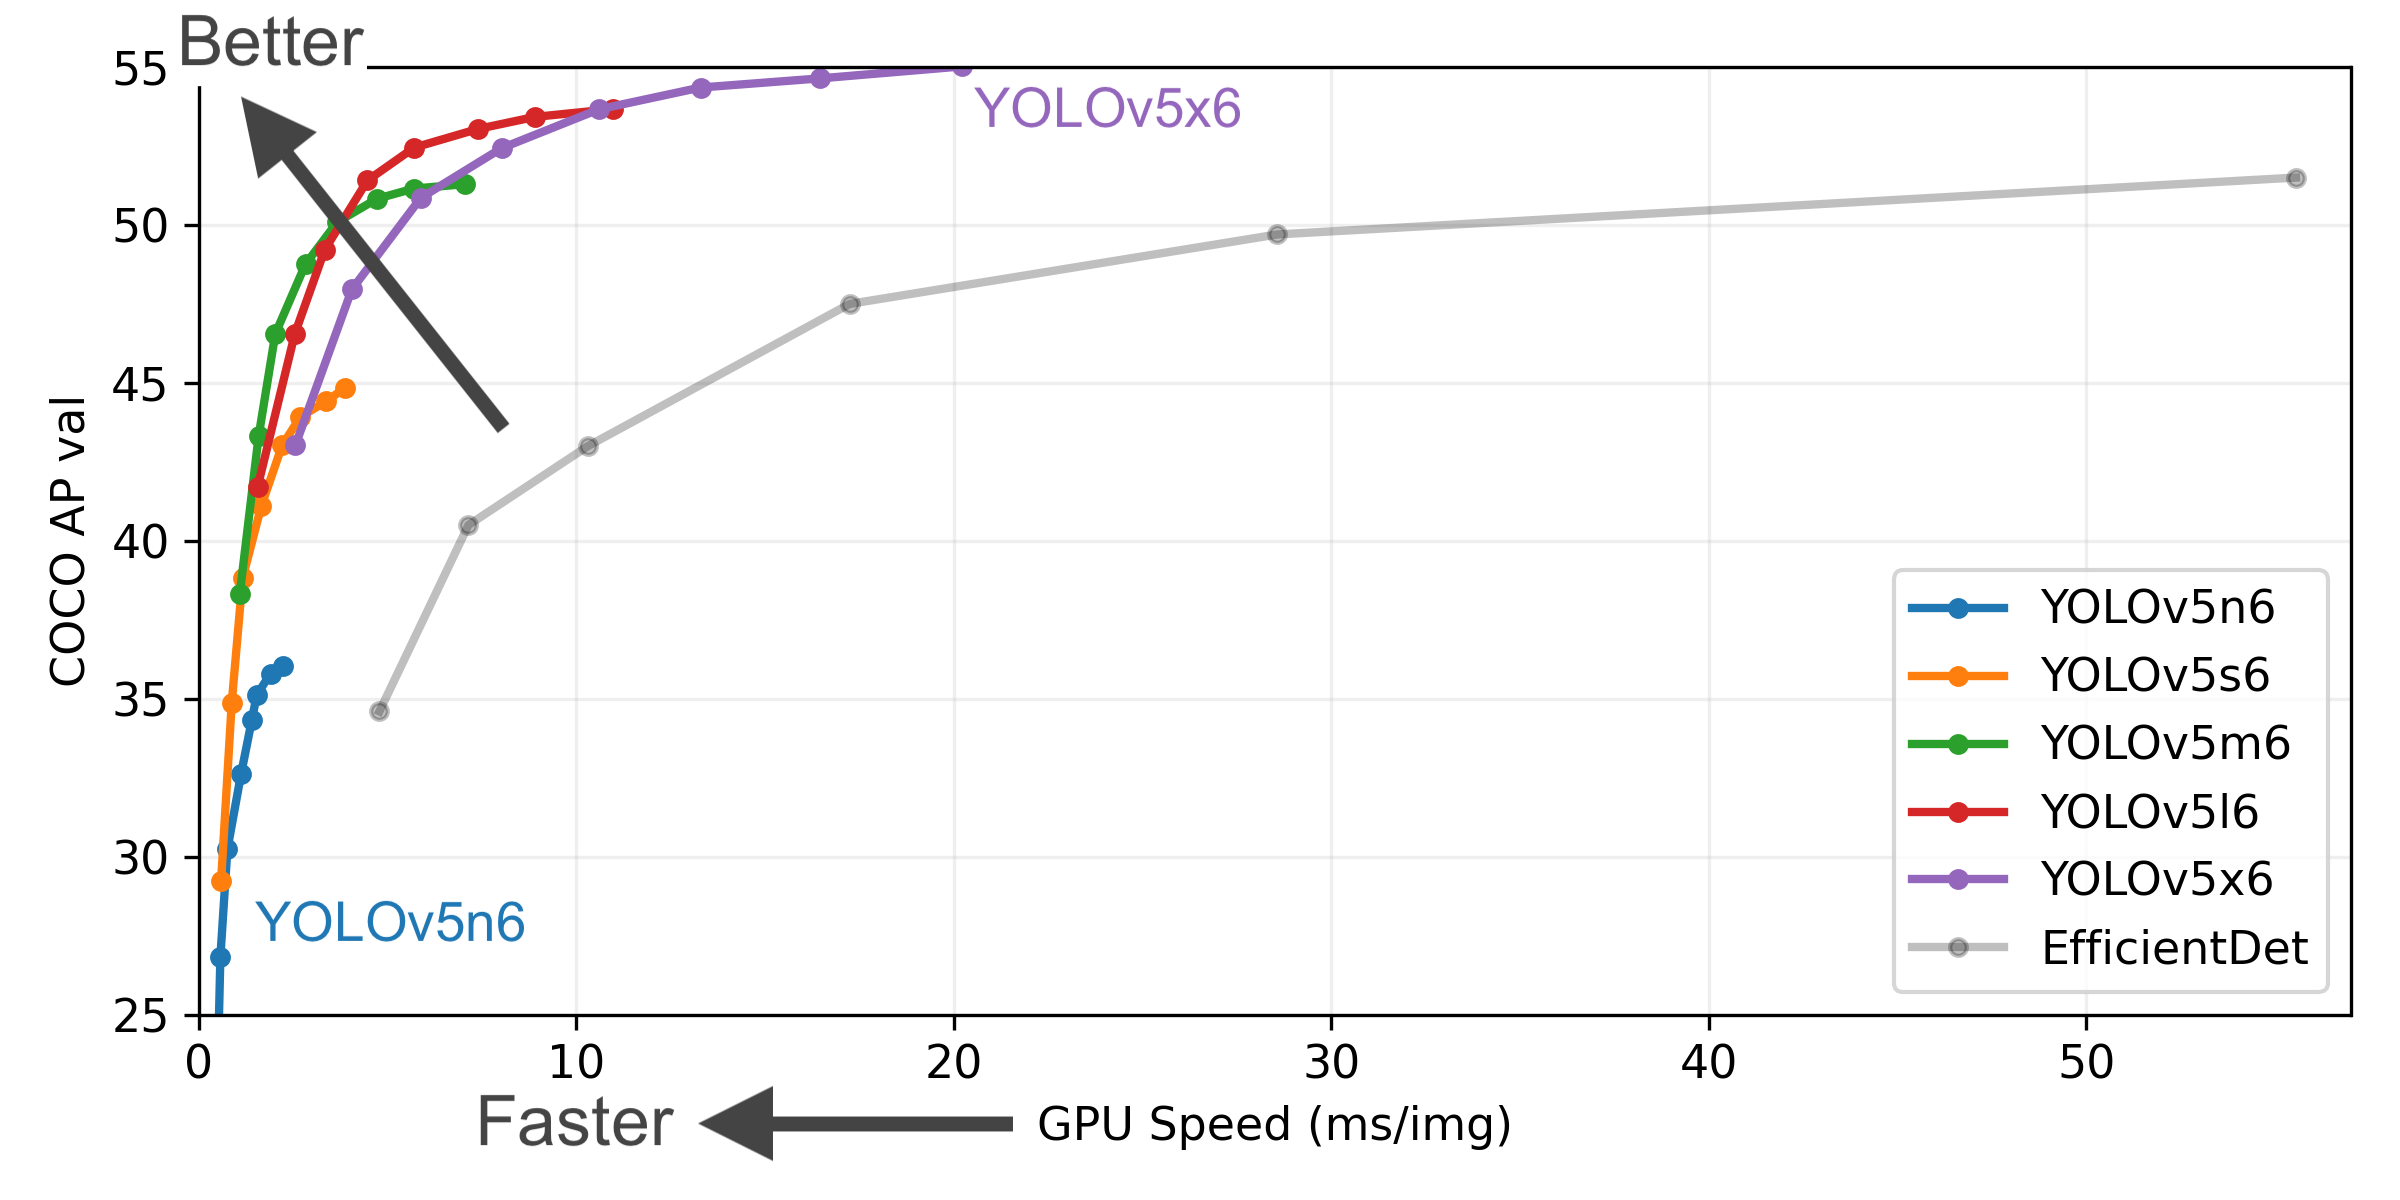

# Importing Libraries

In [ ]:
import random
import ast
import cv2
import argparse
import sys, math
import numpy as np
import pandas as pd
import os,shutil,yaml
from tqdm import tqdm
import tensorflow as tf
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.model_selection import GroupKFold

In [ ]:
# seeding everything

def seed_everything(seed=0):
#     seed(1)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
 
seed = 2022
seed_everything(seed)

# <center><span style="color:#00BFC4;"> Reading Csv </span></center> 
<a id="2"></a>

In [ ]:
train_df = pd.read_csv('../input/tensorflow-great-barrier-reef/train.csv')
base_folder = "../input/tensorflow-great-barrier-reef/train_images"

train_df["path"] = base_folder + "/video_" + \
                    train_df['video_id'].astype(str) + "/" +\
                    train_df['video_frame'].astype(str) +".jpg"
# train_df

In [ ]:
# === Show image and annotations if applicable ===
def show_image(path, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    path: full path to the .jpg image
    annot: string of the annotation for the coordinates of COTS'''
    
    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")

In [ ]:
def show_multiple_images(seq_id, frame_no):
    '''Shows multiple images within a sequence.
    seq_id: a number corresponding with the sequence unique ID
    frame_no: a list containing the first and last frame to plot'''
    
    # Select image paths & their annotations
    paths = list(train_df[(train_df["sequence"]==seq_id) & 
                 (train_df["sequence_frame"]>=frame_no[0]) & 
                 (train_df["sequence_frame"]<=frame_no[1])]["path"])
    annotations = list(train_df[(train_df["sequence"]==seq_id) & 
                 (train_df["sequence_frame"]>=frame_no[0]) & 
                 (train_df["sequence_frame"]<=frame_no[1])]["annotations"])

    # Plot
    fig, axs = plt.subplots(2, 3, figsize=(23, 10))
    axs = axs.flatten()
    fig.suptitle(f"Showing consecutive frames for Sequence ID: {seq_id}", fontsize = 20)

    for k, (path, annot) in enumerate(zip(paths, annotations)):
        axs[k].set_title(f"Frame No: {frame_no[0]+k}", fontsize = 12)
        show_image(path, annot, axs[k])

    plt.tight_layout()
    plt.show()

In [ ]:
seq_id = 59337
frame_no = [70, 75]

show_multiple_images(seq_id, frame_no)


# <center><span style="color:#00BFC4;"> prepare and split data into groupkfold </span></center> 
<a id="3"></a>

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
#     print(np.array(bboxes).shape)
    bboxes = coco2yolo(image_height = 720, image_width = 1280, bboxes = np.array(bboxes))
    bboxes = [[0]+bbox for bbox in bboxes]
    return bboxes

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normalizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes.tolist()

def get_image_path_and_label(ROOT_DIR = None, CSV_DIR = None, FOLD = None, train = True):

    def get_img_path(row):
        row['image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
        return row

    df = pd.read_csv(CSV_DIR)
    df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x))
    df['n_annotations'] = df['annotations'].apply(lambda x: len(x))



    df = df[df['n_annotations'] > 0]
    # print(len(df))
    df['bboxes'] = df['annotations'].apply(get_bbox)
    df = df.apply(get_img_path, axis= 1)
    if FOLD is not None:
        kf = GroupKFold(n_splits = 3)
        df = df.reset_index(drop=True)
        df['fold'] = -1
        for fold, (train_idx, val_idx) in enumerate(kf.split(df, y = df.video_id.tolist(), groups= df.video_id)):
            df.loc[val_idx, 'fold'] = fold
        # display(df.fold.value_counts())

        train_df = df.query('fold != @FOLD')
        val_df = df.query('fold == @FOLD')
    else:
        train_df = df
    if train:
        train_annotations_dict = {}
        train_annotations_dict['image_dir'] = train_df['image_path'].values.tolist()
        train_annotations_dict['labels'] = train_df['bboxes'].values.tolist()
        return train_annotations_dict
    else:
        val_annotations_dict = {}
        val_annotations_dict['image_dir'] = train_df['image_path'].values.tolist()
        val_annotations_dict['labels'] = train_df['bboxes'].values.tolist()
        return val_annotations_dict        

    

# <center><span style="color:#00BFC4;"> Data Reader </span></center> 
<a id="4"></a>

In [ ]:
class DataReader(object):
    '''
    read the image and label from the text information
    resize the image, and adjust the label rect if necessary
    augment the dataset 
    '''
    def __init__(self, hyp, annotations_dict, img_size=640,
                 mosaic=False, augment=False, test = False, rect= False, filter_idx = None):

        self.hyp = hyp
        self.img_size = img_size  # image_target_size
        self.mosaic = mosaic
        self.augment = augment
        self.test = test
        self.image_paths = annotations_dict['image_dir']
        self.labels = annotations_dict['labels']
        self.rect = rect
        self.n = len(self.image_paths)
        self.idx = range(len(self.image_paths))
        if filter_idx is not None:  # filter some samples
            self.idx = [i for i in self.idx if i in filter_idx]
            print('filter {} from {}'.format(len(self.idx), len(self.annotations)))

    def iter(self):
        for i in self.idx:
            yield self[i]
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):


        hyp = self.hyp
        mosaic = self.mosaic and random.random() < hyp['mosaic']
        
        if self.test:
            img, (h0, w0), (h, w)  = self.load_image(index)
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=False)
            return img
        if mosaic:
            # Load mosaic
            img, labels = self.load_mosaic(index)
            shapes = None

            # MixUp augmentation
            if random.random() < hyp['mixup']:
                img, labels = mixup(img, labels, *self.load_mosaic(random.randint(0, self.n - 1)))

        else:
            # Load image
            img, (h0, w0), (h, w) = self.load_image(index)

            # Letterbox
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            labels = np.array(self.labels[index].copy())
            if labels.size:  # normalized xywh to pixel xyxy format
                labels[:, 1:] = xywhn2xyxy(labels[:, 1:], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1])

            if self.augment:
                img, labels = random_perspective(img, labels,
                                                 degrees=hyp['degrees'],
                                                 translate=hyp['translate'],
                                                 scale=hyp['scale'],
                                                 shear=hyp['shear'],
                                                 perspective=hyp['perspective'])

        nl = len(labels)  # number of labels
        if nl:
            labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=img.shape[1], h=img.shape[0], clip=True, eps=1E-3)

        if self.augment:
            # Albumentations
#             img, labels = self.albumentations(img, labels)
            nl = len(labels)  # update after albumentations

            # HSV color-space
            augment_hsv(img, hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v'])

            # Flip up-down
            if random.random() < hyp['flipud']:
                img = np.flipud(img)
                if nl:
                    labels[:, 2] = 1 - labels[:, 2]

            # Flip left-right
            if random.random() < hyp['fliplr']:
                img = np.fliplr(img)
                if nl:
                    labels[:, 1] = 1 - labels[:, 1]
        return img , labels


    def load_image(self, idx):
        # loads 1 image from dataset index 'i', returns (im, original hw, resized hw)
        image_path  = self.image_paths[idx]
        im = cv2.imread(image_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        h0, w0 = im.shape[:2]  # orig hw
        r = self.img_size / max(h0, w0)  # ratio
        if r != 1:  # if sizes are not equal
            im = cv2.resize(im,
                            (int(w0 * r), int(h0 * r)),
                            interpolation=cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA)
            return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized
        else:
            return im, (h0, w0), (h0, w0)

    def load_mosaic(self, index):
        # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
        labels4 = []
        s = self.img_size
        mosaic_border = [-self.img_size // 2, -self.img_size // 2]
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in mosaic_border)  # mosaic center x, y
        indices = [index] + random.choices(self.idx, k=3)  # 3 additional image indices'
#         print(indices)
        random.shuffle(indices)
        for i, index in enumerate(indices):
            # Load image
            img, _, (h, w) = self.load_image(index)
#             print(h, w)
            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            labels = np.array(self.labels[index].copy())
            if labels.size:
                labels[:, 1:5] = xywhn2xyxy(labels[:, 1:5], w, h, padw, padh)  # normalized xywh to pixel xyxy format
            labels4.append(labels)

        # Concat/clip labels
        labels4 = np.concatenate(labels4, 0)

        for x in (labels4[:, 1:]):
            np.clip(x, 0, 2 * s, out=x)  # clip when using random_perspective()


        # Augment
        img4, labels4 = random_perspective(img4, labels4,
                                           degrees=self.hyp['degrees'],
                                           translate=self.hyp['translate'],
                                           scale=self.hyp['scale'],
                                           shear=self.hyp['shear'],
                                           perspective=self.hyp['perspective'],
                                           border=mosaic_border)  # border to remove

        return img4, labels4


# <center><span style="color:#00BFC4;"> Augmentation </span></center> 
<a id="5"></a>

Here online imagespace and colorspace augmentations like flip ,random prespective,hsv augmentation, mixup in the trainloader (but not the val_loader) is used to present a new and unique augmented Mosaic (original image + 3 random images) each time an image is loaded for training. Images are never presented twice in the same way. The hyperparameters used to define these augmentations are in the hyperparameter file defined when training:

In [ ]:
def random_perspective(im, targets=(), degrees=10, translate=.1, scale=.1, shear=10, perspective=0.0,
                       border=(0, 0)):

    # targets = [cls, xyxy]

    height = im.shape[0] + border[0] * 2  # shape(h,w,c)
    width = im.shape[1] + border[1] * 2

    # Center
    C = np.eye(3)
    C[0, 2] = -im.shape[1] / 2  # x translation (pixels)
    C[1, 2] = -im.shape[0] / 2  # y translation (pixels)

    # Perspective
    P = np.eye(3)
    P[2, 0] = random.uniform(-perspective, perspective)  # x perspective (about y)
    P[2, 1] = random.uniform(-perspective, perspective)  # y perspective (about x)

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    # s = 2 ** random.uniform(-scale, scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(0.5 - translate, 0.5 + translate) * width  # x translation (pixels)
    T[1, 2] = random.uniform(0.5 - translate, 0.5 + translate) * height  # y translation (pixels)

    # Combined rotation matrix
    M = T @ S @ R @ P @ C  # order of operations (right to left) is IMPORTANT
    if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
        if perspective:
            im = cv2.warpPerspective(im, M, dsize=(width, height), borderValue=(114, 114, 114))
        else:  # affine
            im = cv2.warpAffine(im, M[:2], dsize=(width, height), borderValue=(114, 114, 114))

    # Visualize
    # import matplotlib.pyplot as plt
    # ax = plt.subplots(1, 2, figsize=(12, 6))[1].ravel()
    # ax[0].imshow(im[:, :, ::-1])  # base
    # ax[1].imshow(im2[:, :, ::-1])  # warped

    # Transform label coordinates
    n = len(targets)
    if n:
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ M.T  # transform
        xy = (xy[:, :2] / xy[:, 2:3] if perspective else xy[:, :2]).reshape(n, 8)  # perspective rescale or affine

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        new = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # clip
        new[:, [0, 2]] = new[:, [0, 2]].clip(0, width)
        new[:, [1, 3]] = new[:, [1, 3]].clip(0, height)

        # filter candidates
        i = box_candidates(box1=targets[:, 1:5].T * s, box2=new.T, area_thr=0.10)
        targets = targets[i]
        targets[:, 1:5] = new[i]

    return im, targets


def mixup(im, labels, im2, labels2):
    # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
    r = np.random.beta(32.0, 32.0)  # mixup ratio, alpha=beta=32.0
    im = (im * r + im2 * (1 - r)).astype(np.uint8)
    labels = np.concatenate((labels, labels2), 0)
    return im, labels


def box_candidates(box1, box2, wh_thr=2, ar_thr=100, area_thr=0.1, eps=1e-16):  # box1(4,n), box2(4,n)
    # Compute candidate boxes: box1 before augment, box2 after augment, wh_thr (pixels), aspect_ratio_thr, area_ratio
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    ar = np.maximum(w2 / (h2 + eps), h2 / (w2 + eps))  # aspect ratio
    return (w2 > wh_thr) & (h2 > wh_thr) & (w2 * h2 / (w1 * h1 + eps) > area_thr) & (ar < ar_thr)  # candidates

def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
    rand = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * rand[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * rand[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * rand[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

# <center><span style="color:#00BFC4;"> Utility Function </span></center> 
<a id="6"></a>

**LetterBox** - letterbox function adapts input images to meet minimum stride length constraints in order to make up the remainder of the width and height for multiple of 32.

In [ ]:
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y


def xyxy2xywhn(x, w=640, h=640, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    y = np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=64):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

# 
# <center><span style="color:#00BFC4;"> Model Architecture </span></center> 
<a id="7"></a>

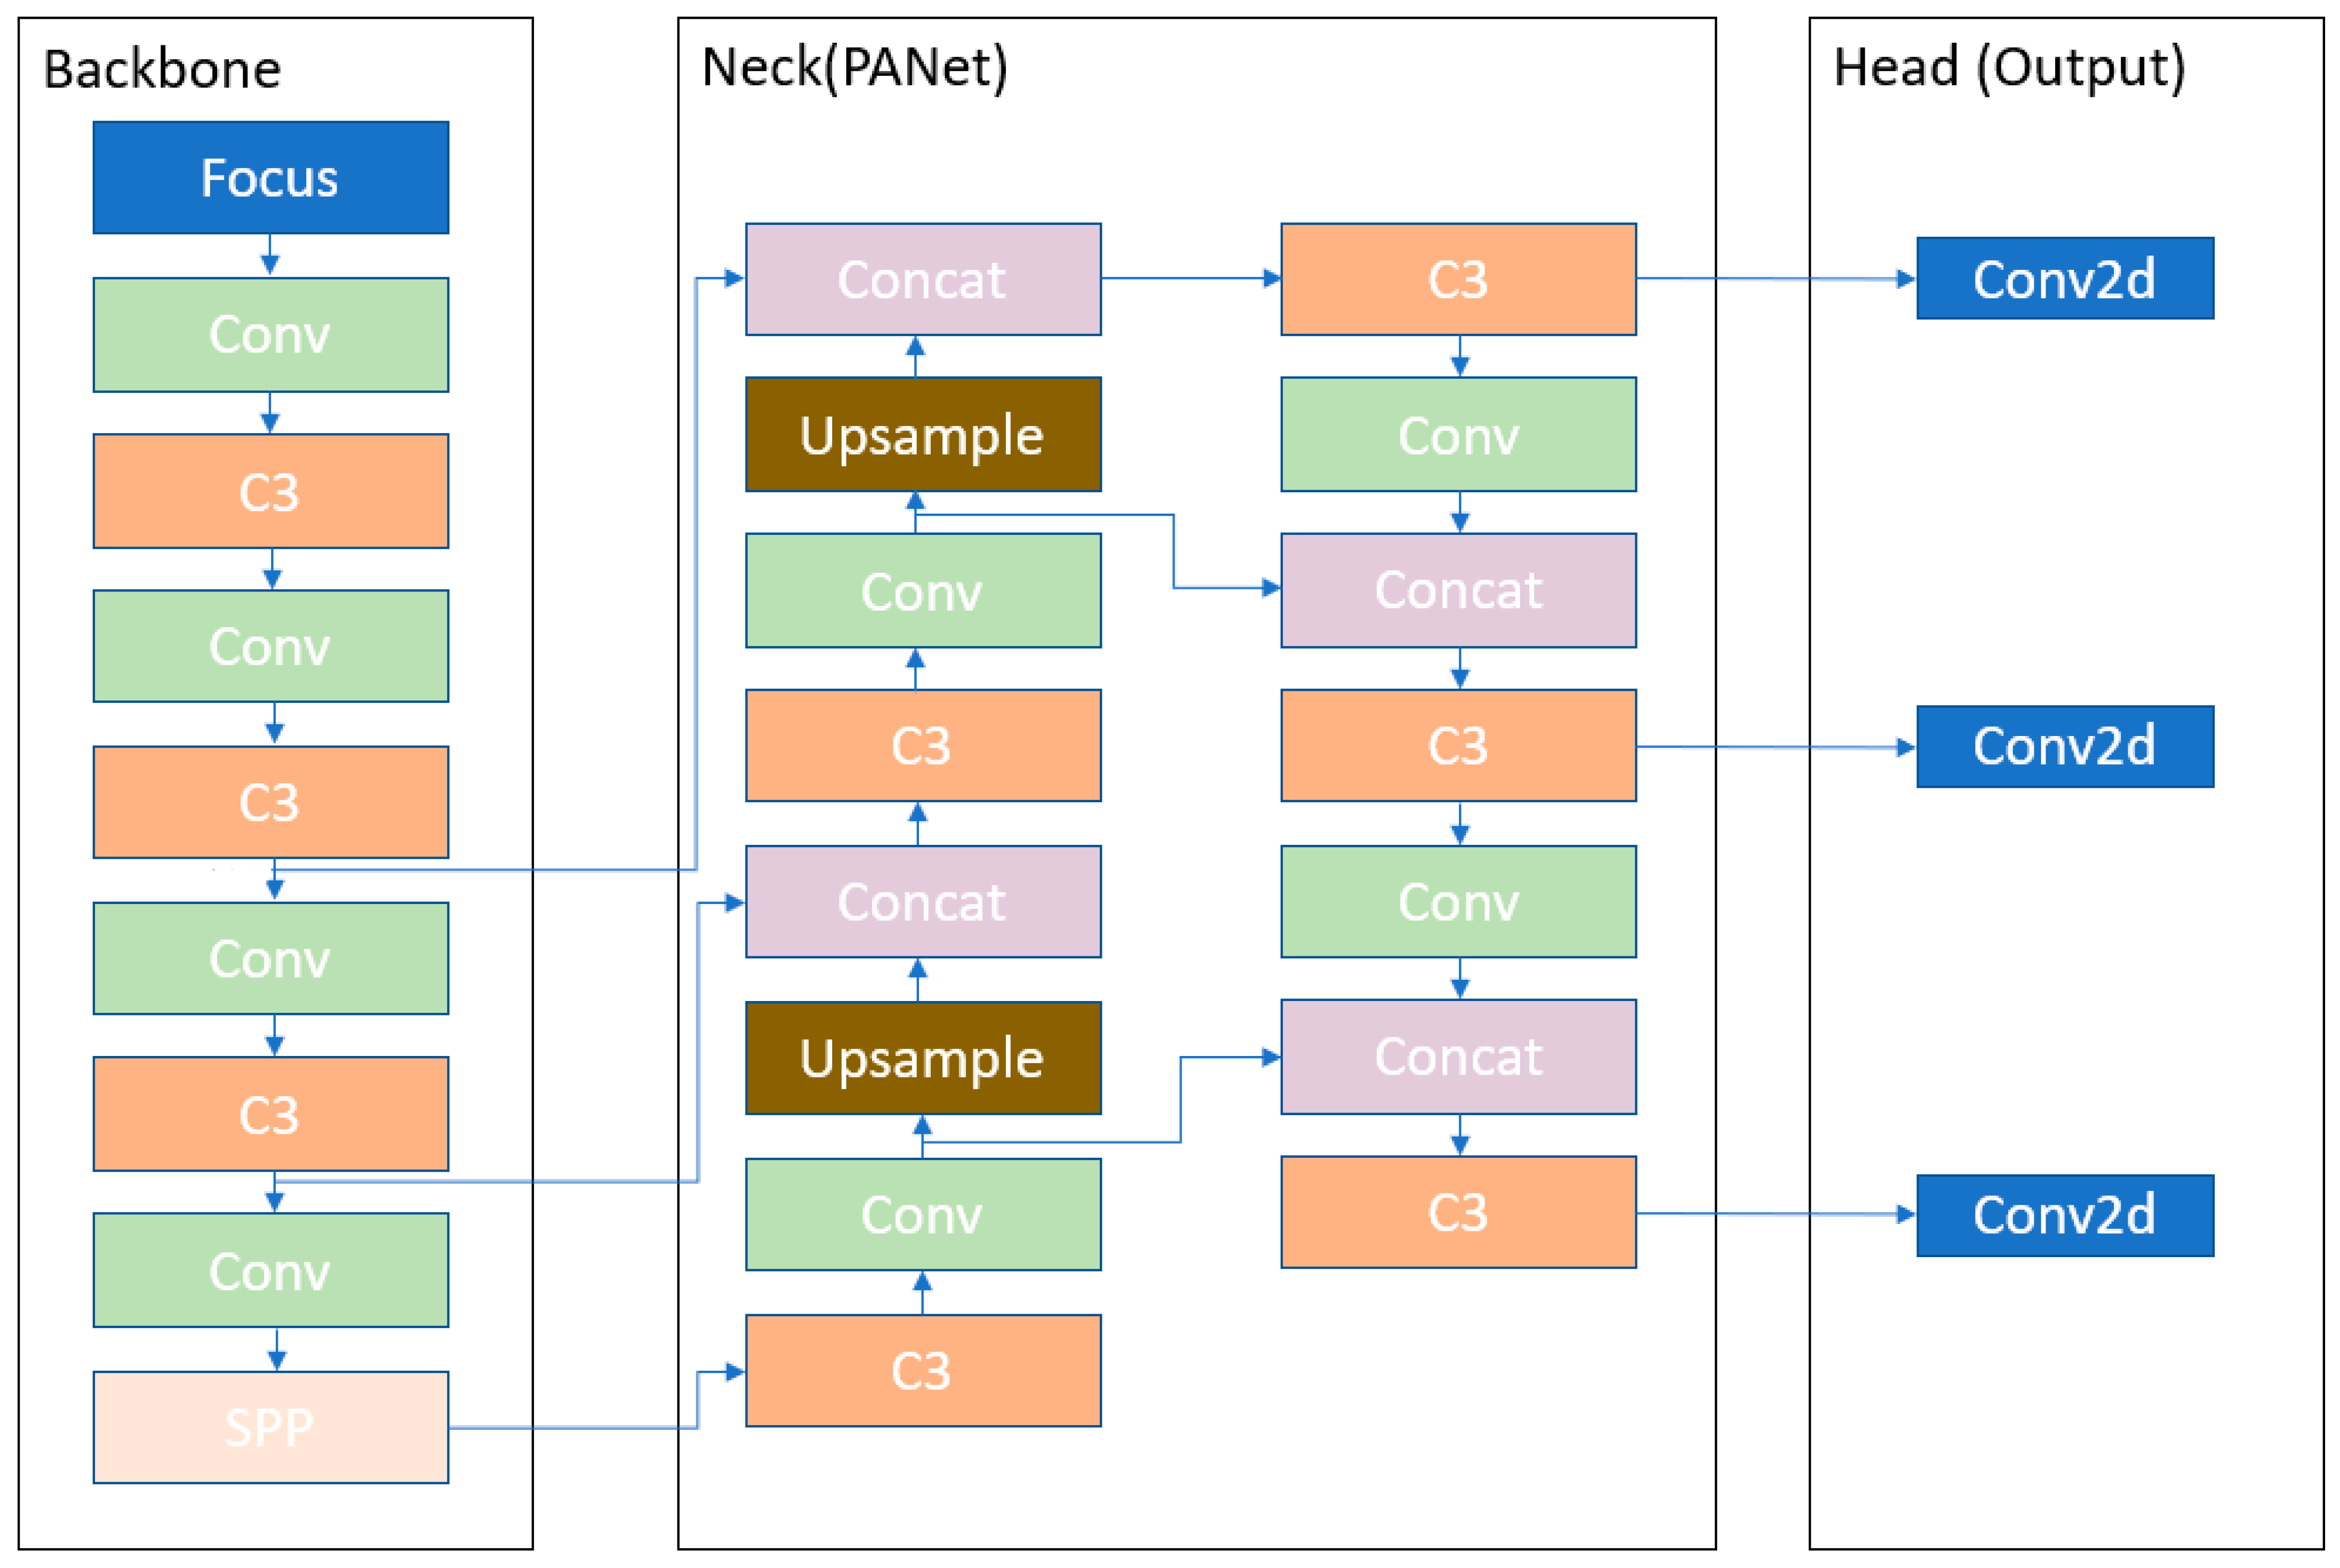

Yolov5 architecture mainly consisted of three parts, namely-


 
1. Backbone: Model Backbone is mostly used to extract key features from an input image. CSP(Cross Stage Partial Networks) are used as a backbone in YOLO v5 to extract rich in useful characteristics from an input image.

2. Neck: The Model Neck is mostly used to create feature pyramids. Feature pyramids aid models in generalizing successfully when it comes to object scaling. It aids in the identification of the same object in various sizes and scales.
Feature pyramids are quite beneficial in assisting models to perform effectively on previously unseen data. Other models, such as FPN, BiFPN, and PANet, use various sorts of feature pyramid approaches.

PANet is used as a neck in YOLO v5 to get feature pyramids.

3. Head: The model Head is mostly responsible for the final detection step. It uses anchor boxes to construct final output vectors with class probabilities, objectness scores, and bounding boxes.

In above figure the architecture of
YOLOv5 algorithm is presented. The Focus layer is evolved from YOLOv3 structure.
It replaces the first three layers of YOLOv3 and create a single layer in YOLOv5. Additionally, here Conv denotes a convolution layer. C3 is composed of three convolution layers
and a module cascaded by various bottlenecks. Spatial pyramid pooling (SPP) is a pooling
layer that is used to remove the fixed size constraint of the network. Upsample is used in
upsampling the previous layer fusion in the nearest node. Concat is a slicing layer and is
used to slice the previous layer. The last 3 Conv2d are detection modules used in the head
of the network.

# Model Definition

### Batch normalization
Almost every convolutional layer in Yolo has batch normalization after it. It helps the model train faster and reduces variance between units (and total variance as well). Batch normalization is defined as follows.
<br>
![](https://hsto.org/files/005/d19/2bd/005d192bd6274c298f75896498aea377.png)
<br>
`_BATCH_NORM_EPSILON` refers to epsilon in this formula, whereas `_BATCH_NORM_DECAY` refers to momentum, which is used for computing moving average and variance. We use them in forward propagation during inference (after training).
<br>
<br>
`moving_average = momentum * moving_average + (1 - momentum) * current_average`

**Swish Activation function**:

Mathematical formula: Y = X * sigmoid(X)\
Bounded below but Unbounded above: Y approach to constant value at X approaches negative infinity but Y approach to infinity as X approaches infinity.
Derivative of Swish, Y’ = Y + sigmoid(X) * (1-Y)\
Soft curve and non-monotonic function.

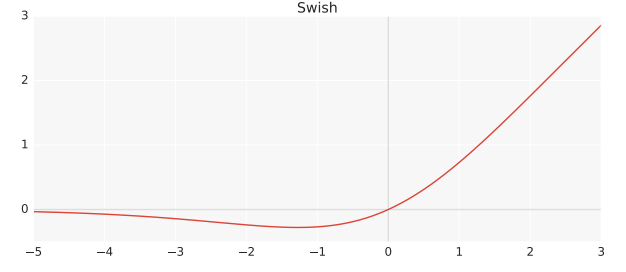

### Anchors
Anchors are sort of bounding box priors, that were calculated on the COCO dataset using k-means clustering. We are going to predict the width and height of the box as offsets from cluster centroids. The center coordinates of the box relative to the location of filter application are predicted using a sigmoid function.
<br>
$$b_{x} = \sigma(t_{x})+c_{x}$$
$$b_{y} = \sigma(t_{y})+c_{y}$$
$$b_{w} = p_{w}e^{t_{w}}$$
$$b_{h} = p_{h}e^{t_{h}}$$
<br>
Where $b_{x}$ and $b_{y}$ are the center coordinates of the box, $b_{w}$ and $b_{h}$ are the width and height of the box, $c_{x}$ and $c_{y}$ are the location of filter application and $t_{i}$ are predicted during regression.

Anchor box is just a scale and aspect ratio of specific object classes in object detection. The FPN (Future Pyramid Network) has three outputs and each output's role is to detect objects according to their scale. For example:

P3/8 is for detecting smaller objects.
P4/16 is for detecting medium objects.
P5/32 is for detecting bigger objects.

So when you're going to detect smaller objects you need to use smaller anchor boxes and for medium objects you should use medium scale anchor boxes, so on. You can see it on following image as well:

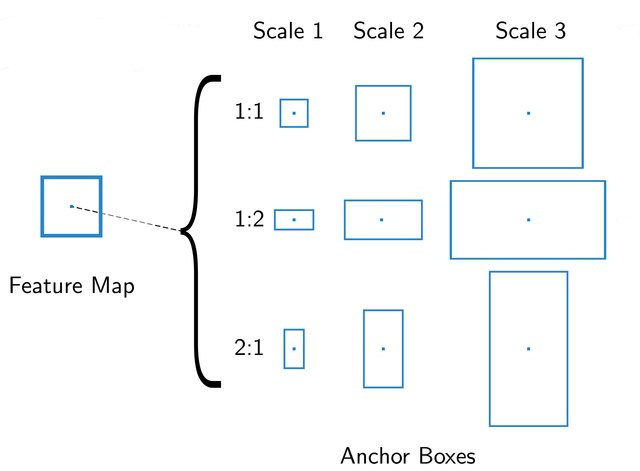

You may have a question why bigger feature maps have smaller anchor boxes. It's because, during downsampling the feature maps if you downsample it many times you may lose smaller objects, that's why you should use bigger feature maps and smaller anchor boxes to detect smaller objects.

you can see the anchors yaml file [here](https://github.com/ultralytics/yolov5/blob/master/models/hub/anchors.yaml) to know more about anchors width and height used.

# outputs of yolov5

yolov5 gives 3 or 4 outputs depending upon the architecture. the last dimension of yolov5 outputs will be no of classes + 5(4 bounding box coordinates , 1 confidence score)

As we can see from above that yolov5 uses 3 scales for P5 and 4 scales for P6 and outputs differnet scales( image_size / 16, image_size / 32, image_size / 64)  for difffernet sized objects.

For example if we have image size of 640 , stride (8, 16, 32), no of classes 1 then the model outputs will be of shape (bs, 3, 80, 80, 6),  (bs, 3, 40, 40, 6), (bs, 3, 20, 20, 6) where 6 (no of classes + 5)



In [ ]:
weight_decay = 0.0005

class BN(keras.layers.Layer):
    # TensorFlow BatchNormalization wrapper
    def __init__(self, w=None):
        super().__init__()
        self.bn = keras.layers.BatchNormalization()

    def call(self, inputs, training = True):
        return self.bn(inputs)


class Pad(keras.layers.Layer):
    def __init__(self, pad):
        super().__init__()
        self.pad = tf.constant([[0, 0], [pad, pad], [pad, pad], [0, 0]])

    def call(self, inputs):
        return tf.pad(inputs, self.pad, mode='constant', constant_values=0)
    
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
        return p
    else:
        return p

class Conv(keras.layers.Layer):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True, w=None):
        # ch_in, ch_out, weights, kernel, stride, padding, groups
        super().__init__()
        assert g == 1, "TF v2.2 Conv2D does not support 'groups' argument"
        assert isinstance(k, int), "Convolution with multiple kernels are not allowed."

        conv = keras.layers.Conv2D(
            c2, k, s, 'SAME' if s == 1 else 'VALID', use_bias=False,
        kernel_regularizer = regularizers.l2(weight_decay))
        self.conv = conv if s == 1 else keras.Sequential([Pad(autopad(k, p)), conv])
        self.bn = BN()# if hasattr(w, 'bn') else tf.identity
        
        # YOLOv5 activations

        self.act = (lambda x: keras.activations.swish(x)) if act else tf.identity


    def call(self, inputs):
        return self.act(self.bn(self.conv(inputs)))


class Focus(keras.layers.Layer):
    # Focus wh information into c-space
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True, w=None):
        # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, g, act)

    def call(self, inputs):  # x(b,w,h,c) -> y(b,w/2,h/2,4c)
        # inputs = inputs / 255  # normalize 0-255 to 0-1
        return self.conv(tf.concat([inputs[:, ::2, ::2, :],
                                    inputs[:, 1::2, ::2, :],
                                    inputs[:, ::2, 1::2, :],
                                    inputs[:, 1::2, 1::2, :]], 3))


class Bottleneck(keras.layers.Layer):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5, w=None):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def call(self, inputs):
        return inputs + self.cv2(self.cv1(inputs)) if self.add else self.cv2(self.cv1(inputs))


class Conv2d(keras.layers.Layer):
    # Substitution for PyTorch nn.Conv2D
    def __init__(self, c1, c2, k, s=1, g=1, bias=True, w=None):
        super().__init__()
        assert g == 1, "TF v2.2 Conv2D does not support 'groups' argument"
        self.conv = keras.layers.Conv2D(
            c2, k, s, 'VALID', use_bias=bias,kernel_regularizer = regularizers.l2(weight_decay)
)

    def call(self, inputs):
        return self.conv(inputs)


class BottleneckCSP(keras.layers.Layer):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5, w=None):
        # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1, w=w.cv4)
        self.bn = BN()
        self.act = lambda x: keras.activations.relu(x, alpha=0.1)
        self.m = keras.Sequential([Bottleneck(c_, c_, shortcut, g, e=1.0, w=w.m[j]) for j in range(n)])

    def call(self, inputs):
        y1 = self.cv3(self.m(self.cv1(inputs)))
        y2 = self.cv2(inputs)
        return self.cv4(self.act(self.bn(tf.concat((y1, y2), axis=3))))


class C3(keras.layers.Layer):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5, w=None):
        # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1, 1)
        self.m = keras.Sequential([Bottleneck(c_, c_, shortcut, g, e=1.0) for j in range(n)])

    def call(self, inputs):
        return self.cv3(tf.concat((self.m(self.cv1(inputs)), self.cv2(inputs)), axis=3))


class SPP(keras.layers.Layer):
    # Spatial pyramid pooling layer used in YOLOv3-SPP
    def __init__(self, c1, c2, k=(5, 9, 13), w=None):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = [keras.layers.MaxPool2D(pool_size=x, strides=1, padding='SAME') for x in k]

    def call(self, inputs):
        x = self.cv1(inputs)
        return self.cv2(tf.concat([x] + [m(x) for m in self.m], 3))


class SPPF(keras.layers.Layer):
    # Spatial pyramid pooling-Fast layer
    def __init__(self, c1, c2, k=5, w=None):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = keras.layers.MaxPool2D(pool_size=k, strides=1, padding='SAME')

    def call(self, inputs):
        x = self.cv1(inputs)
        y1 = self.m(x)
        y2 = self.m(y1)
        return self.cv2(tf.concat([x, y1, y2, self.m(y2)], 3))


class Detect(keras.layers.Layer):
    def __init__(self, nc=80, anchors=(), ch=(), imgsz=(640, 640), w=None):  # detection layer
        super().__init__()

        
        self.nc = nc  # number of classes
        self.no = nc + 5  # number of outputs per anchor
        self.nl = len(anchors)  # number of detection layers
#         print(anchors)
        self.na = len(anchors[0]) // 2  # number of anchors
        self.grid = [tf.zeros(1)] * self.nl  # init grid
        if self.nl == 4:
            self.stride = tf.convert_to_tensor(np.array([8, 16, 32,64], np.float32))
        elif self.nl == 3:
            self.stride = tf.convert_to_tensor(np.array([8, 16, 32], np.float32))
            
#         self.anchors = tf.convert_to_tensor(anchors, dtype=tf.float32)
#         print(anchors)
        self.anchors = tf.cast(tf.reshape(anchors, [self.nl, -1, 2]), tf.float32)
        
        self.anchor_grid = tf.reshape(self.anchors * tf.reshape(self.stride, [self.nl, 1, 1]),
                                      [self.nl, 1, -1, 1, 2])
          # fixed here, modify if structure changes
        
        self.m = [Conv2d(x, self.no * self.na, 1) for i, x in enumerate(ch)]
          # set to False after building model
        self.imgsz = imgsz
        for i in range(self.nl):
            ny, nx = self.imgsz[0] // self.stride[i], self.imgsz[1] // self.stride[i]
            self.grid[i] = self._make_grid(nx, ny)

    def call(self, inputs, training = True):
        z = []  # inference output
        x = []
        for i in range(self.nl):
            x.append(self.m[i](inputs[i]))
            # x(bs,20,20,255) to x(bs,3,20,20,85)
            ny, nx = self.imgsz[0] // self.stride[i], self.imgsz[1] // self.stride[i]
            x[i] = tf.transpose(tf.reshape(x[i], [-1, ny , nx, self.na, self.no]), [0, 3,1, 2, 4])

            if not training:  # inference
                x[i] = tf.cast(x[i], tf.float32)
                xtemp = tf.reshape(x[i], [-1, self.na, ny * nx , self.no])
                y = tf.sigmoid(xtemp)
                xy = (y[..., 0:2] * 2 - 0.5 + self.grid[i]) * self.stride[i]  # xy
                wh = (y[..., 2:4] * 2) ** 2 * self.anchor_grid[i]  / self.stride[i]
                # Normalize xywh to 0-1 to reduce calibration error
#                 xy /= tf.constant([[self.imgsz[1], self.imgsz[0]]], dtype=tf.float32)
#                 wh /= tf.constant([[self.imgsz[1], self.imgsz[0]]], dtype=tf.float32)
                y = tf.concat([xy, wh, y[..., 4:]], -1)
                z.append(tf.reshape(y, [-1, self.na * ny * nx, self.no]))

        return x if training else (tf.concat(z, 1), x)

    @staticmethod
    def _make_grid(nx=20, ny=20):

        xv, yv = tf.meshgrid(tf.range(nx), tf.range(ny))
        return tf.cast(tf.reshape(tf.stack([xv, yv], 2), [1, 1, ny * nx, 2]), dtype=tf.float32)


class Upsample(keras.layers.Layer):
    def __init__(self, size, scale_factor, mode, w=None):  # warning: all arguments needed including 'w'
        super().__init__()
        assert scale_factor == 2, "scale_factor must be 2"
        self.upsample = lambda x: tf.image.resize(x, (x.shape[1] * 2, x.shape[2] * 2), method=mode)
        # self.upsample = keras.layers.UpSampling2D(size=scale_factor, interpolation=mode)
        # with default arguments: align_corners=False, half_pixel_centers=False
        # self.upsample = lambda x: tf.raw_ops.ResizeNearestNeighbor(images=x,
        #                                                            size=(x.shape[1] * 2, x.shape[2] * 2))

    def call(self, inputs):
        return self.upsample(inputs)


class Concat(keras.layers.Layer):
    def __init__(self, dimension=1, w=None):
        super().__init__()
        assert dimension == 1, "convert only NCHW to NHWC concat"
        self.d = 3

    def call(self, inputs):
        return tf.concat(inputs, self.d)
    
def make_divisible(x, divisor):
    # Returns nearest x divisible by divisor
    if isinstance(divisor, tf.Tensor):
        divisor = int(divisor.max())  # to int
    return math.ceil(x / divisor) * divisor


# Model Class


#def parse_model - parse-model function parses the model yaml file containing details of architecture 

Non-max suppression :
The model is going to produce a lot of boxes, so we need a way to discard the boxes with low confidence scores. Also, to avoid having multiple boxes for one object, we will discard the boxes with high overlap as well using non-max suppresion for each class.

Yolo class forward method gives the logits during training and if nms is True in evaluation then it gives refined boxes .

In [ ]:
class Yolo(object):
    def __init__(self, yaml_dir, params, img_size, tf_nms = False, conf = None, iou_thrs = None, training = True,
                max_output_size_per_class = 30, max_total_size = 50):

        self.tf_nms = tf_nms
        with open(yaml_dir) as f:
            yaml_dict = yaml.load(f, Loader=yaml.FullLoader)
        yaml_dict['nc'] = 1
        self.params = params
        self.module_list = self.parse_model(yaml_dict, ch = [3], imgsz = [img_size[0], img_size[1]])
        module = self.module_list[-1]
        self.training = training

        self.conf = conf
        self.iou_thrs = iou_thrs
        self.max_output_size_per_class = max_output_size_per_class
        self.max_total_size = max_total_size
        if isinstance(module, Detect):
            # transfer the anchors to grid coordinator, 3 * 3 * 2
            module.anchors /= tf.reshape(module.stride, [-1, 1, 1])
     
    def __call__(self, img_size,  name='yolo'):
        x = tf.keras.Input([img_size[0], img_size[1], 3])
        output = self.forward(x)
        return tf.keras.Model(inputs=x, outputs=output, name=name)

    def forward(self, x):
        y = []
        for module in self.module_list:
            if module.f != -1:  # if not from previous layer
                if isinstance(module.f, int):
                    x = y[module.f]
                else:
                    x = [x if j == -1 else y[j] for j in module.f]
            if isinstance(module, Detect):
                x = module(x, self.training)
            else:
                x = module(x)
            y.append(x)
        

        # Add TensorFlow NMS
        if self.tf_nms:
            boxes = self._xywh2xyxy(x[0][..., :4])
            probs = x[0][:, :, 4:5]
            classes = x[0][:, :, 5:]
            scores = probs * classes

#             boxes = tf.cast(tf.reshape(boxes, [12,3,-1, 4]), tf.float32)
#             scores = tf.cast(tf.reshape(scores, [12,3,-1, 6]), tf.float32)
            boxes = tf.expand_dims(boxes, axis = 2)
            print(scores, boxes)
            nms = tf.image.combined_non_max_suppression(boxes, 
                                                    scores, 
                                                    self.max_output_size_per_class,
                                                    self.max_total_size, 
                                                    self.iou_thrs, 
                                                    self.conf, 
                                                    clip_boxes=False)
            return nms
        return x 
    
    def parse_model(self, d, ch, imgsz):  # model_dict, input_channels(3)
        anchors, nc, gd, gw = d['anchors'], d['nc'], d['depth_multiple'], d['width_multiple']
        na = (len(anchors[0]) // 2) if isinstance(anchors, list) else anchors  # number of anchors
        no = na * (nc + 5)  # number of outputs = anchors * (classes + 5)
        layers, save, c2 = [], [], ch[-1]  # layers, savelist, ch out
        for i, (f, n, m, args) in enumerate(d['backbone'] + d['head']):  # from, number, module, args
            m = m.replace('nn.', '') if isinstance(m, str) else m
            m_str = m
            m = eval(m) if isinstance(m, str) else m  # eval strings
            for j, a in enumerate(args):
                try:
                    args[j] = eval(a) if isinstance(a, str) else a  # eval strings
                except NameError:
                    pass

            n = max(round(n * gd), 1) if n > 1 else n  # depth gain
            if m in [Conv2d, Conv, Bottleneck, SPP, SPPF, Focus, BottleneckCSP, C3]:
                c1, c2 = ch[f], args[0]
                c2 = make_divisible(c2 * gw, 8) if c2 != no else c2

                args = [c1, c2, *args[1:]]
                if m in [BottleneckCSP, C3]:
                    args.insert(2, n)
                    n = 1
            
            elif m is BN:
                args = [ch[f]]
            elif m is Concat:
                c2 = sum(ch[-1 if x == -1 else x + 1] for x in f)
            elif m is Detect:
                args.append([ch[x + 1] for x in f])
                if isinstance(args[1], int):  # number of anchors
                    args[1] = [list(range(args[1] * 2))] * len(f)
                args.append(imgsz)
            else:
                c2 = ch[f]
            
            tf_m = eval(m) if isinstance(m, str) else m
            m_ = tf.keras.Sequential(*[tf_m(*args) for _ in range(n)]) if n > 1 else tf_m(*args)
            m_.i, m_.f = i, f
            layers.append(m_)
            ch.append(c2)
        return layers
    
    @staticmethod
    def _xywh2xyxy(xywh):
        # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
        x, y, w, h = tf.split(xywh, num_or_size_splits=4, axis=-1)
        return tf.concat([x - w / 2, y - h / 2, x + w / 2, y + h / 2], axis=-1)




# <center><span style="color:#00BFC4;"> Yolo Loss </span></center> 
<a id="9"></a>

YOLO loss function is composed of three parts:

box_loss — bounding box regression loss (Mean Squared Error).\
obj_loss — the confidence of object presence is the objectness loss (Binary Cross Entropy).\
cls_loss — the classification loss (Cross Entropy).

Since this Dataset has only one class to so cls loss is always Zero.

In [ ]:

def bbox_iou(bbox1, bbox2, xyxy=False, giou=False, diou=False, ciou=False, epsilon=1e-7):
    assert bbox1.shape == bbox2.shape
    # giou loss: https://arxiv.org/abs/1902.09630
    if xyxy:
        b1x1, b1y1, b1x2, b1y2 = bbox1[..., 0], bbox1[..., 1], bbox1[..., 2], bbox1[..., 3]
        b2x1, b2y1, b2x2, b2y2 = bbox2[..., 0], bbox2[..., 1], bbox2[..., 2], bbox2[..., 3]
    else:  # xywh -> xyxy
        b1x1, b1x2 = bbox1[..., 0] - bbox1[..., 2] / 2, bbox1[..., 0] + bbox1[..., 2] / 2
        b1y1, b1y2 = bbox1[..., 1] - bbox1[..., 3] / 2, bbox1[..., 1] + bbox1[..., 3] / 2
        b2x1, b2x2 = bbox2[..., 0] - bbox2[..., 2] / 2, bbox2[..., 0] + bbox2[..., 2] / 2
        b2y1, b2y2 = bbox2[..., 1] - bbox2[..., 3] / 2, bbox2[..., 1] + bbox2[..., 3] / 2

    # intersection area
    inter = tf.maximum(tf.minimum(b1x2, b2x2) - tf.maximum(b1x1, b2x1), 0) * \
            tf.maximum(tf.minimum(b1y2, b2y2) - tf.maximum(b1y1, b2y1), 0)

    # union area
    w1, h1 = b1x2 - b1x1 + epsilon, b1y2 - b1y1 + epsilon
    w2, h2 = b2x2 - b2x1+ epsilon, b2y2 - b2y1 + epsilon
    union = w1 * h1 + w2 * h2 - inter + epsilon

    # iou
    iou = inter / union

    if giou or diou or ciou:
        # enclosing box
        cw = tf.maximum(b1x2, b2x2) - tf.minimum(b1x1, b2x1)
        ch = tf.maximum(b1y2, b2y2) - tf.minimum(b1y1, b2y1)
        if giou:
            enclose_area = cw * ch + epsilon
            giou = iou - 1.0 * (enclose_area - union) / enclose_area
            return tf.clip_by_value(giou, -1, 1)
        if diou or ciou:
            c2 = cw ** 2 + ch ** 2 + epsilon
            rho2 = ((b2x1 + b2x2 - b1x1 - b1x2) ** 2 + (b2y1 + b2y2 - b1y1 - b1y2) ** 2) / 4
            if diou:
                return iou - rho2 / c2
            elif ciou:
                v = (4 / math.pi ** 2) * tf.pow(tf.atan(w2 / h2) - tf.atan(w1 / h1), 2)
                alpha = v / (v - iou + (1 + epsilon))
                return iou - (rho2 / c2 + v * alpha)
    return tf.clip_by_value(iou, 0, 1)

def smooth_BCE(eps=0.1):  
    # return positive, negative label smoothing BCE targets
    return 1.0 - 0.5 * eps, 0.5 * eps

class ComputeLoss:
    # Compute losses
    def __init__(self, hyp, model, autobalance=False):
        self.sort_obj_iou = False

        det = model.module_list[-1]
        
        self.balance = [4.0, 1.0, 0.4] if det.nl == 3 else [4.0, 1.0, 0.25, 0.06,0.02]
        
        self.ssi = list(det.stride).index(16) if autobalance else 0  # stride 16 index
        self.gr, self.hyp, self.autobalance = 1.0, hyp, autobalance
        
        self.cp, self.cn = smooth_BCE(eps= hyp.get('label_smoothing', 0.0))  # positive, negative BCE targets
        for k in 'na', 'nc', 'nl', 'anchors':
            setattr(self, k, getattr(det, k))
    
    def __call__(self, targets, pred):  # , targets,predictions

        lcls, lbox, lobj = tf.zeros(1, dtype = tf.float32), tf.zeros(1, dtype = tf.float32), tf.zeros(1, dtype = tf.float32)
        tcls, tbox, indices, anchors = self.build_targets(pred, targets)  # targets

        # Losses
        for i, pi in enumerate(pred):  # layer index, layer predictions
            b, a, gj, gi = indices[i]  # batch_image_index, anchor, gridy, gridx
            tobj = tf.zeros_like(pi[..., 0], dtype = tf.float32)  # target obj
            indexes = tf.concat([b[:, tf.newaxis], a[:, tf.newaxis], gj[:, tf.newaxis], gi[:, tf.newaxis]], axis = 1)

            n = b.shape[0]  # number of targets
            if n:

                ps = tf.gather_nd(pi , indexes)

                # Regression
                pxy = tf.nn.sigmoid(ps[:, :2]) * 2 - 0.5
                pwh = (tf.nn.sigmoid(ps[:, 2:4] * 2)) ** 2 * anchors[i]
                pbox = tf.concat((pxy, pwh), 1)  # predicted box

                iou = bbox_iou(pbox, tbox[i], xyxy=False, ciou=True)  # iou(prediction, target)
                lbox += tf.reduce_mean(1.0 - iou) # iou loss

                # Objectness
                score_iou = tf.cast(tf.clip_by_value(iou, 0, 1), dtype = tobj.dtype)
                if self.sort_obj_iou:
                    sort_id = tf.argsort(score_iou)
                    b, a, gj, gi, score_iou = b[sort_id], a[sort_id], gj[sort_id], gi[sort_id], score_iou[sort_id]
                updates = (1.0 - self.gr) + self.gr * score_iou  # iou ratio
                tobj = tf.tensor_scatter_nd_update(tobj, indexes, updates)
                
                
                # Classification
                if self.nc > 1:  # cls loss (only if multiple classes)
                    t = tf.experimental.numpy.full_like(ps[:, 5:], self.cn)  # targets
                    index = tf.concat([tf.expand_dims(tf.range(n, dtype = tf.int64),axis = 1), 
                                       tf.expand_dims(tcls[i], axis = 1)], axis =  1)
                    t = tf.tensor_scatter_nd_update(t , index, [self.cp] * index.shape[0])

                    lcls += tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(t,
                                                        ps[:, 5:],
                                                        pos_weight = self.hyp['cls_pw']))

            obji = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(tobj,
                                                            pi[..., 4],
                                                            pos_weight = self.hyp['obj_pw']))
         
            lobj += obji * self.balance[i]  # obj loss
            if self.autobalance:
                self.balance[i] = self.balance[i] * 0.9999 + 0.0001 / obji.detach().item()

        if self.autobalance:
            self.balance = [x / self.balance[self.ssi] for x in self.balance]

        lbox *= self.hyp['box']
        lobj *= self.hyp['obj']
        lcls *= self.hyp['cls']
        bs = tobj.shape[0]  # batch size

        return (lbox + lobj + lcls) * bs, tf.concat((lbox, lobj, lcls), axis = 0)

    
    def build_targets(self,p, targets):
        # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
        na, nt = self.na, tf.shape(targets)[1]  # number of anchors, targets
        tcls, tbox, indices, anch = [], [], [], []
        gain = tf.ones(7, dtype = tf.float32)  # normalized to gridspace gain
        ai = tf.tile(tf.expand_dims(tf.range(start = 0, limit = na, dtype = tf.float32), axis = 1), [1,nt])
        targets = tf.concat([tf.tile(targets, (na,1,1)), ai[:, :, None]], axis = 2)
        g = 0.5  # bias

        off = tf.constant([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1]], tf.float32) * g  # offsets

        for i in range(self.nl):
            anchors = self.anchors[i]

            updates = tf.cast(tf.gather(tf.constant(p[i].shape), [3,2,3,2]) , gain.dtype)
            gain  =  tf.tensor_scatter_nd_update(gain, [[2],[3],[4],[5]], updates)
            # Match targets to anchors
            scaled_label = targets * gain # label coordinator now is the same with anchors

            if nt:
                # Matches
                r = scaled_label[:, :, 4:6] / anchors[:, None]  # wh ratio
                matched_matrix = tf.reduce_max(tf.math.maximum(r, 1 / r),axis=2) < self.hyp['anchor_t']  # => n_anchor * n_gt
                

                scaled_label = scaled_label[matched_matrix] # filter
#             

                # Offsets
                gxy = scaled_label[:, 2:4]  # grid xy

                gxi = gain[2:4] - gxy  # inverse
#                 
                j, k = tf.transpose(((gxy % 1 < g) & (gxy > 1)) , [1,0])
                l, m = tf.transpose((gxi % 1 < g) & (gxi > 1), [1,0])
                j = tf.stack((tf.ones_like(j), j, k, l, m), axis = 0)

                scaled_label = tf.expand_dims(scaled_label, axis = 0)
                scaled_label = tf.tile(scaled_label, (5,1, 1))[j]
                offsets = (tf.zeros_like(gxy)[None] + off[:, None])[j]
            else:
                scaled_label = targets[0]
                offsets = 0

            # Define

            b ,c = tf.transpose(tf.cast(scaled_label[:, 0:2],tf.int64),  [1,0])  # image, class

            gxy = scaled_label[:, 2:4]  # grid xy
            gwh = scaled_label[:, 4:6]  # grid wh
#             gxy,gwh, c, b = tf.split(scaled_label , [2,2,1,1])
            gij = tf.cast((gxy - offsets), tf.float32)
            
            gi, gj = tf.transpose(gij, [1,0])  # grid xy indices

            # Append
            a = tf.cast(scaled_label[:, 6] , tf.int64)  # anchor indices
            indices.append((b, a, tf.cast(tf.clip_by_value(gj, 0, gain[3] - 1),tf.int64), tf.cast(tf.clip_by_value(gi, 0, gain[2] - 1), tf.int64)))  # image, anchor, grid indices
            tbox.append(tf.concat((gxy - gij, gwh), 1))  # box
            anch.append(tf.gather(anchors, a))  # anchors
            tcls.append(c)  # class

        return tcls, tbox, indices, anch

# <center><span style="color:#00BFC4;"> Training </span></center> 
<a id="10"></a>

I have tried to implement the training part as similar to original pytorch implementation but there are few key steps which tensorflow doesnt allow like differnet lr for weights and bias of same layer(although it provides different lr for layers) which slows the training a little bit as compare to original repo.


i have padded the dataset due to unequal bounding box in each image. so data from **tf.data.Dataset.from_generator** is first unpadded in function unpad_labels before passing to the model.


* **exponential moving average**(ema) is used to maintain moving averages of the trained parameters and it also increases the mean average precision(map) of the model.
* mixed precision is used for faster training along with scaled loss scale optimizer to prevent underflow. Tensorflow provide **tf.keras.mixed_precision.LossScaleOptimizer** api that dynamically update the loss scale so we dont need to manually choose it.

in training i have not wrapped the training step with @tf.function because the shape of target is not same for all image so the yolov5 target boxes shape are different. one method could be to predefined the anchors shape but that takes lot of GPU memory so i decided not to wrap train function in graph.

during training i have used pretrained checkpoint which has been converted to tf format in this [notebook](https://www.kaggle.com/ashusma/yolov5-pytorch-to-tensorflow-checkpoint).Outputs of both pytorch and tensorflow model is same as you can see in the notebook. i have converted only few models but one can convert any model given in official repository to tensorflow using the code given in notebook

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

class DataLoader(object):

    def __init__(self, data_reader, img_size=640):
        self.data_reader = data_reader
        self.img_size = img_size


    def __call__(self, batch_size=8):

        dataset = tf.data.Dataset.from_generator(self.data_reader.iter,
                                 output_types=(tf.float32, tf.float32),
                                 output_shapes=([self.img_size, self.img_size, 3], [None, 5]))


        dataset = dataset.padded_batch(batch_size, 
                                   padded_shapes=([None, None, 3],[80, 5]),
                                   padding_values=(None, -1.0), drop_remainder = True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        return dataset

def one_cycle(y1=0.0, y2=1.0, steps=100):
    # lambda function for sinusoidal ramp from y1 to y2 https://arxiv.org/pdf/1812.01187.pdf
    return lambda x: ((1 - math.cos(x * math.pi / steps)) / 2) * (y2 - y1) + y1

    
class Trainer(object):
    """ Trainer class that uses the dataset and model to train
    # Usage
    data_loader = tf.data.Dataset()
    trainer = Trainer(params)
    trainer.train(data_loader)
    """
    def __init__(self, opt, hyp, nbs):
        """ Constructor
        :param params: dict, with dir and training parameters
        """
        self.hyp = hyp
        
        self.weights, self.cfg, self.epochs, self.batch_size, self.img_size, self.optim, self.cos_lr,self.save_dir = \
        opt.weights, opt.cfg, opt.epochs, opt.batch_size , opt.imgsz ,opt.optimizer, opt.cos_lr, opt.save_dir
         
        self.nbs = nbs // self.batch_size
        if self.cos_lr:
            self.lf = one_cycle(1, self.hyp['lrf'], self.epochs)
        else:
            self.lf = lambda x: (1 - x / self.epochs) * (1.0 - self.hyp['lrf']) + self.hyp['lrf']
            
        self.global_step = tf.Variable(0, trainable=False, dtype=tf.int64)
        if not os.path.exists(self.save_dir):  # make dir if not exists
            os.mkdir(self.save_dir)
        self.build_model()
        

    def build_model(self):
        """ Build the model,
        define the training strategy and model, loss, optimizer
        :return:
        """
        self.strategy = tf.distribute.get_strategy()
        
        with self.strategy.scope():
            self.model = Yolo(yaml_dir= self.cfg, img_size = [self.img_size, self.img_size], params = self.hyp)

#             self.num_classes = self.model.module_list[-1].num_classes
            self.loss_sum = tf.keras.metrics.Sum(name='sum', dtype=None)
            self.loss_fn = ComputeLoss(self.hyp, self.model)

            if self.optim == 'SGD':
                self.optimizer = tf.keras.optimizers.SGD(lr = self.hyp['lr0'], momentum = self.hyp['momentum'], nesterov=True)
            elif self.optim == 'Adam':
                self.optimizer = tf.keras.optimizers.Adam(lr = self.hyp['lr0'] , beta_1 = self.hyp['momentum'])
            else:
                self.optimizer = tfa.optimizers.AdamW(lr = self.hyp['lr0'], weight_decay = self.hyp['weight_decay'],
                                                     beta_1 = self.hyp['momentum'])
              
            self.optimizer = tfa.optimizers.MovingAverage(self.optimizer)
            self.optimizer = mixed_precision.LossScaleOptimizer(self.optimizer)
            

        self.stride = self.model.module_list[-1].stride
        self.nl = self.model.module_list[-1].nl
        self.nc = self.model.module_list[-1].nc
        self.hyp['box'] *= 3 / self.nl  # scale to layers
        self.hyp['cls'] *= self.nc / 80 * 3 / self.nl  # scale to classes and layers
        self.hyp['obj'] *= (self.img_size / 640) ** 2 * 3 / self.nl  # scale to image size and layers
        
    def train(self, train_dataset, valid_dataset=None, transfer='scratch'):
        """ train function
        :param train_dataset: train dataset built by tf.data
        :param valid_dataset: valid dataset build by td.data, optional
        :param transfer: pretrain
        :return:
        """

        with self.strategy.scope():

            # => tf.keras.Model
            self.model = self.model([self.img_size, self.img_size])
            self.model.summary()
            self.model.load_weights(self.weights)

#         train_dataset = self.strategy.experimental_distribute_dataset(train_dataset)        

        nw = max(round(self.hyp['warmup_epochs'] * self.nbs), 100)
        for epoch in range(self.epochs):
            
            mean_loss = tf.zeros(3, dtype = np.float32)
            pbar = tqdm(enumerate(train_dataset), total = self.nbs)
            
            for step, (image, target) in pbar:
                
                ni = step + self.nbs * epoch
                xi = [0, nw]
                 
                if ni <= nw:
                    # warmup lr
                    # all lrs rise from 0.0 to lr0
                    lr = np.interp(ni, xi , [0.0, self.hyp['lr0'] * self.lf(epoch)])
                    self.optimizer.learning_rate.assign(lr) 

                loss, loss_items = self.train_step(image, target)
                mean_loss = (mean_loss * step + loss_items) / (step + 1)
                
                # print epoch  iou_loss  obj_loss  class_loss  img_size using pbar
                pbar.set_description(('%10s' * 1 + '%10.4g' *4) % (
                    f'{epoch}/{self.epochs - 1}', *mean_loss, self.img_size))

               
            self.model.save_weights(os.path.join(self.save_dir, f'model_epoch{epoch}.h5')) # save weights 
            if epoch+1 >= hyp['warmup_epochs']:
                lr = self.lf(epoch) * self.hyp['lr0']
                self.optimizer.learning_rate.assign(lr)    
            
            


    def unpad_labels(self,target):

        target = tf.stack([tf.concat([tf.fill([tf.shape(bbox)[0],1], tf.cast(i, tf.float32)) , bbox], axis = 1) for i, bbox in enumerate(target)], axis = 0)
        index = tf.where(tf.not_equal(tf.reduce_sum(target[:, :, 1:],axis= -1), -5))
        target = tf.gather_nd(target, index)
        return target
    

    def train_step(self, image, target):
        target = self.unpad_labels(target)

        with tf.GradientTape() as tape:
            logit = self.model(image, training=True)
            logit = [tf.cast(pred, tf.float32) for pred in logit]
            total_loss, loss_items = self.loss_fn(target[tf.newaxis, :,:], logit)
            scaled_loss = self.optimizer.get_scaled_loss(total_loss)
        scaled_gradients = tape.gradient(scaled_loss, self.model.trainable_variables)
        
        gradients = self.optimizer.get_unscaled_gradients(scaled_gradients)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.loss_sum.update_state(total_loss)
        self.global_step.assign_add(1)    
        return total_loss, loss_items

In [ ]:
class opt:
    hyp = '../input/tf-yolov5/tf yolov5/hyp.yaml'
    root_dir = '../input/tensorflow-great-barrier-reef'
    imgsz = 640
    batch_size = 12
    weights = '../input/tf-yolov5/tf yolov5/checkpoints/yolo5s.h5'
    cfg = '../input/tf-yolov5/tf yolov5/model_cfg/yolov5s.yaml'
    epochs = 4
    cos_lr = True
    optimizer = 'SGD'
    save_dir = '/kaggle/working/yolov5_trained_model'

In [ ]:
if isinstance(opt.hyp, str):
    with open(opt.hyp, errors='ignore') as f:
        hyp = yaml.safe_load(f)  # load hyps dict


csv_path = opt.root_dir + '/train.csv'
train_annotations_dict = get_image_path_and_label(opt.root_dir, csv_path)
nbs = len(train_annotations_dict['image_dir'])
trainer = Trainer(opt, hyp, nbs)
reader = DataReader(hyp = hyp, 
                        annotations_dict = train_annotations_dict,
                        img_size = opt.imgsz,
                        mosaic = True, 
                        augment = True,
                        )

dataloader = DataLoader(reader, opt.imgsz)
train_dataset = dataloader(opt.batch_size)


**before training lets visualize the images how it looks like after preprocessing and augmentations**

In [ ]:
# a = iter(train_dataset)
for image , label in train_dataset.unbatch().take(6):
    plt.imshow(image[:, :, 0])
    plt.show()

now that we have visualized the training data lets stat training.
here i am training for 4 epoch,but one should train for more epoch and with larger resolution to get better result .

In [ ]:
trainer.train(train_dataset) 

although the prediction wont be too good since we have trained the model only for 4 epoch and low resolution but still lets visualize what model has learnt

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[1, 0, 0]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
#         print(box)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [ ]:
# defining val dataset

val_annotations_dict = get_image_path_and_label(opt.root_dir, csv_path, train = False)
nbs = len(val_annotations_dict['image_dir'])
trainer = Trainer(opt, hyp, nbs)
reader = DataReader(hyp = hyp, 
                        annotations_dict = val_annotations_dict,
                        img_size = opt.imgsz,
                        mosaic = False, 
                        augment = False,
                        )

dataloader = DataLoader(reader, opt.imgsz)
val_dataset = dataloader(opt.batch_size)

# define the model and load trained weights

model = Yolo(yaml_dir= opt.cfg, img_size = [opt.imgsz, opt.imgsz], params = opt.hyp, tf_nms= True, conf = 0.15, iou_thrs = 0.50, training = False)
model = model([opt.imgsz, opt.imgsz])
model.load_weights('/kaggle/working/yolov5_trained_model/model_epoch3.h5')

In [ ]:
for image, label in val_dataset.unbatch().take(6):
    image = tf.expand_dims(image, axis=  0)
    pred = model(image, training = False)
#     print(pred[0].shape)
    boxes, classes, scores = pred[0].numpy()[0] , pred[2].numpy()[0], pred[1].numpy()[0]
    ax = visualize_detections(image[0], boxes, classes, scores) 

In this notebook i have covered all the codes necessary to replicate the result of yolov5 in Tensorflow but
official yolov5 has many more extra features like (hyperparmeter evolution , autoanchor, onnx, and many more) which is not possible to implement in one notebook .so i would to request to go through their repository and codes to get the good grasp of yolov5 and its inner working and implement it in tensorflow as it will teach you very finer details of working of both framework.It took me quite some time to implement code in tensorflow but it was a great learning.

# Reference

[official yolov5 implentation by ultralytics](https://github.com/ultralytics/yolov5)
